# v9fs performance studies

First thing we need to do is start a qemu with a kernel.  The versions of both of these matter if what we are doing is qemu-virtio as transport (and probably also have an impact on qemu network performance)

TODO:
- [ ] TASK: add build configuraton for [qemu | kernel | u-root | etc]

# Setup Test Environment

The following command starts qemu in the background.  You can optionally set the QEMU command line and KERNEL to use as environment variables.
You must be setup for kvm and the user must have permission to start kvm instances without sudo (usually by being in group kvm).

Okay, so this all works ... but we don't have any nice way to cleanup, so we'll have to work that out at some point.

In [ ]:
QEMU = "../qemu/build/qemu-system-x86_64"
KERNEL = "../build/arch/x86_64/boot/bzImage"


In [ ]:
!sg kvm -c '{QEMU} -kernel \
    {KERNEL} \
	-cpu  max \
    -s   \
    -enable-kvm \
    -m 8192m \
    -machine q35  \
    -initrd /tmp/initramfs.linux_amd64.cpio \
    -object rng-random,filename=/dev/urandom,id=rng0 \
    -device virtio-rng-pci,rng=rng0 \
    -device vhost-vsock-pci,guest-cid=42 \
    -device virtio-net-pci,netdev=n1 \
    -netdev user,id=n1,hostfwd=tcp:127.0.0.1:17010-:17010,net=192.168.1.0/24,host=192.168.1.1 \
    -debugcon file:debug.log -global isa-debugcon.iobase=0x402 \
    -fsdev local,security_model=passthrough,id=fsdev0,path=/tmp \
    -device virtio-9p-pci,id=fs0,fsdev=fsdev0,mount_tag=hostshare \
    -daemonize'

# Run a test

Okay, so now we need some simple tests to run in this environment.  We'll do this all over cpu.  Most operations will be stored in bench.py, but we'll configure them here



In [ ]:
# run this cell during debug to make sure underlying python modules reload
%load_ext autoreload
%autoreload 2

In [102]:
#!/usr/bin/python
from bench import BenchTarget, BenchProgress, bandwidth
from IPython.display import clear_output, display
import logging
import pandas as pd

npfs = BenchTarget("npfs", ["../npfs/fs/npfs", "-p", "5640", "-w", "8", "-s"], "/mnt/9/test", "netfstab")
p9ufs = BenchTarget("p9ufs",["../p9/cmd/p9ufs/p9ufs","0.0.0.0:5640"], "/mnt/9/test", "netfstab")
virtio = BenchTarget("virtio","","/mnt/9/test", "virtiofstab")
cpud = BenchTarget("cpu", "", "./test", "fstab")

testcfgs = [ virtio, npfs, p9ufs, cpud ]
blocksizes = [ 131072, 65536, 32768, 16384, 8192, 4096, 1024, 512 ]

def stepDesc( notes, s, t):
    clear_output(wait=True)
    print( notes + "["+str(s)+"/"+str(t)+"]")

prog = BenchProgress(len(testcfgs)*len(blocksizes)*5, stepDesc)

logger = logging.getLogger()
logging.basicConfig(filename="log.txt", level=logging.DEBUG)

results = bandwidth( testcfgs, blocksizes, 5, blocksizes[0]*10000, "notebook test", prog, logger) 

clear_output(wait=True)
display(results)


,Run Config,Target,Blocksize,Iteration,Bandwidth
0,100,virtio,131072,0,747.0
1,100,virtio,131072,1,746.0
2,100,virtio,131072,2,786.0
3,100,virtio,131072,3,756.0
4,100,virtio,131072,4,631.0
...,...,...,...,...,...
155,100,cpu,512,0,1.7
156,100,cpu,512,1,1.7
157,100,cpu,512,2,1.7
158,100,cpu,512,3,1.7


# Process results from a particular run

Collapse iterations to mean, min, max, and standard deviation

In [103]:
import bench

processed = bench.refine(results)
display(processed)

,Target,Blocksize,MeanBW,MinBW,MaxBW,MaxStdD
0,virtio,131072,733.20,631.0,786.0,59.386025
1,virtio,65536,718.40,595.0,780.0,76.277782
2,virtio,32768,463.20,448.0,483.0,13.026895
3,virtio,16384,286.20,233.0,330.0,42.605164
4,virtio,8192,174.20,135.0,202.0,28.787150
5,virtio,4096,94.42,79.3,104.0,11.014854
6,virtio,1024,28.90,27.1,30.4,1.254990
7,virtio,512,14.54,13.6,15.0,0.572713
8,npfs,131072,197.80,194.0,202.0,3.563706
9,npfs,65536,180.20,173.0,188.0,6.610598


# Graph Results

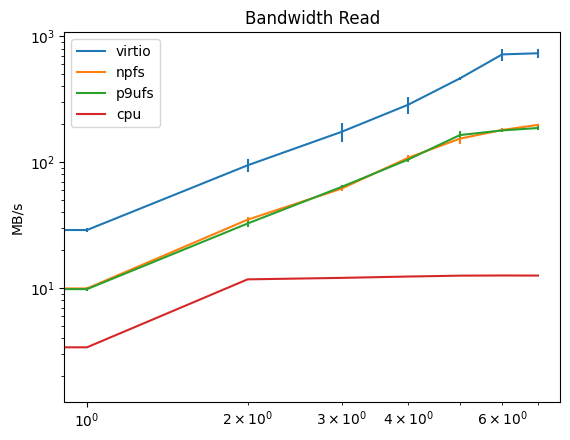

In [169]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
ax = plt.gca()
blocksizes = [ 131072, 65536, 32768, 16384, 8192, 4096, 1024, 512 ]
v = processed.query('Target == "virtio"').sort_values('Blocksize')
v.plot(x='Blocksize',y='MeanBW', yerr='MaxStdD', xlabel="Blocksize", ylabel="MB/s", label="virtio", logx=True, logy=True,ax=ax,use_index=False, title="Bandwidth Read")
n = processed.query('Target == "npfs"').sort_values('Blocksize')
n.plot(x='Blocksize',y='MeanBW', yerr='MaxStdD', xlabel="Blocksize", ylabel="MB/s", label="npfs", logx=True, logy=True,ax=ax,use_index=False)
u = processed.query('Target == "p9ufs"').sort_values('Blocksize')
u.plot(x='Blocksize',y='MeanBW', yerr='MaxStdD', xlabel="Blocksize", ylabel="MB/s", label="p9ufs", logx=True, logy=True,ax=ax,use_index=False)
c = processed.query('Target == "cpu"').sort_values('Blocksize')
c.plot(x='Blocksize',y='MeanBW', yerr='MaxStdD', xlabel="Blocksize", ylabel="MB/s", label="cpu", logx=True, logy=True,ax=ax,use_index=False)


v = processed.query('Target == "virtio"').sort_values('Blocksize')
#v["MeanBW"].plot(use_index=False)
